In [ ]:
pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 3.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=67f8094e4204a345f8b15e96e4be2bab1fd1b6bf812e5660df551f462dd2c760
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:

from sklearn.datasets import load_iris
import numpy as np
from matplotlib.pyplot import subplots, cm
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

iris = load_iris()
print(iris.keys())
X = iris.data # contains sepal length, sepal width, petal length, petal width
y = iris.target # 0,1,2 for the three species setosa, versicolor, virginica respectively
# X shape = (150, 4)


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


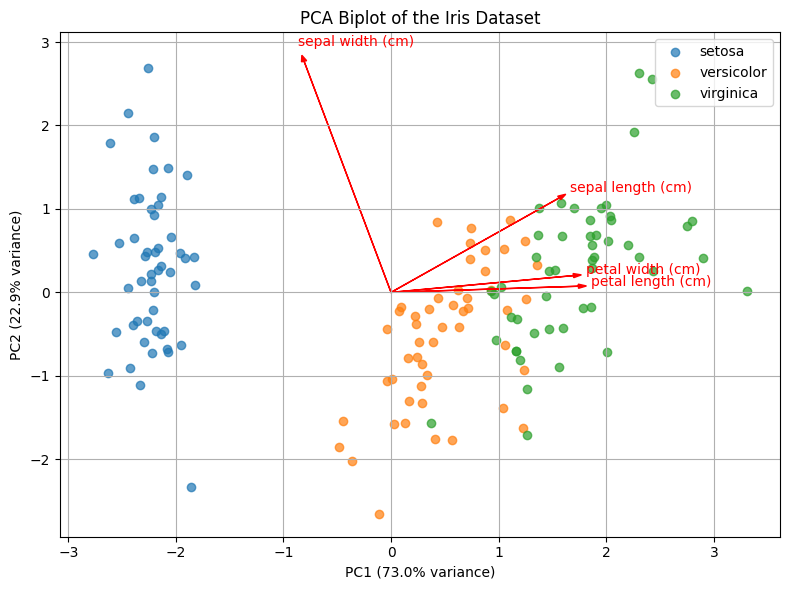

In [ ]:

# Assuming X, y, X_train, y_train, X_test, y_test are already defined
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y, test_size=0.5, random_state=0)
target_names = iris.target_names
feature_names = iris.feature_names

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
pc1_var = pca.explained_variance_ratio_[0]
pc2_var = pca.explained_variance_ratio_[1]

# Graph the biplot
fig, ax = subplots(figsize=(8, 6))

# Scatter points (colored by species)
for i, name in enumerate(target_names):
    ax.scatter(
        X_pca[y == i, 0],
        X_pca[y == i, 1],
        label=name,
        alpha=0.7
    )

# Draw feature arrows
loadings = pca.components_.T   # shape (4,2)

for i, feature in enumerate(feature_names):
    ax.arrow(0, 0,
             loadings[i, 0] * 3,   # scale arrows so it looks good on the graph
             loadings[i, 1] * 3,
             color='red',
             head_width=0.05)
    ax.text(loadings[i, 0] * 3.2,
            loadings[i, 1] * 3.2,
            feature,
            color='red')

ax.set_xlabel(f"PC1 ({pc1_var:.1%} variance)")
ax.set_ylabel(f"PC2 ({pc2_var:.1%} variance)")
ax.set_title("PCA Biplot of the Iris Dataset")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In the biplot, petal length and petal width have the longest arrows along PC1, which explains most of the variance. This means these two features are the most important contributors to the first principal component. Their arrows are almost perfectly aligned and point in the same direction, indicating that they are highly positively correlated: flowers with longer petals also tend to have wider petals. Because this main direction of variation also separates the species well, petal length and petal width are the most useful features for classifying the Iris flowers.

Next, I would perform Support Vector Machine with multiple classes, and see how well it create clusters using the 4 variables. Since it is infeasible to plot data in the 4 dimensions, I would plot data based on the most important contributors to the first principal component which are determined in previous part, namely petal width and petal length.



{'C': 1, 'gamma': 0.5}
Train confusion:
Truth       0   1   2
Predicted            
0          29   0   0
1           0  18   2
2           0   0  26
Test confusion:
Truth       0   1   2
Predicted            
0          21   0   0
1           0  29   1
2           0   1  23


Text(0, 0.5, 'petal width (cm)')

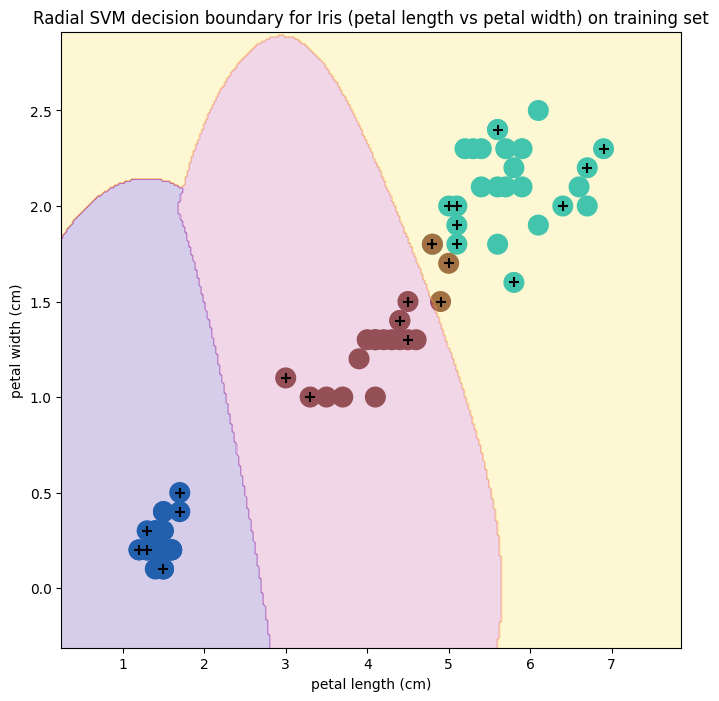

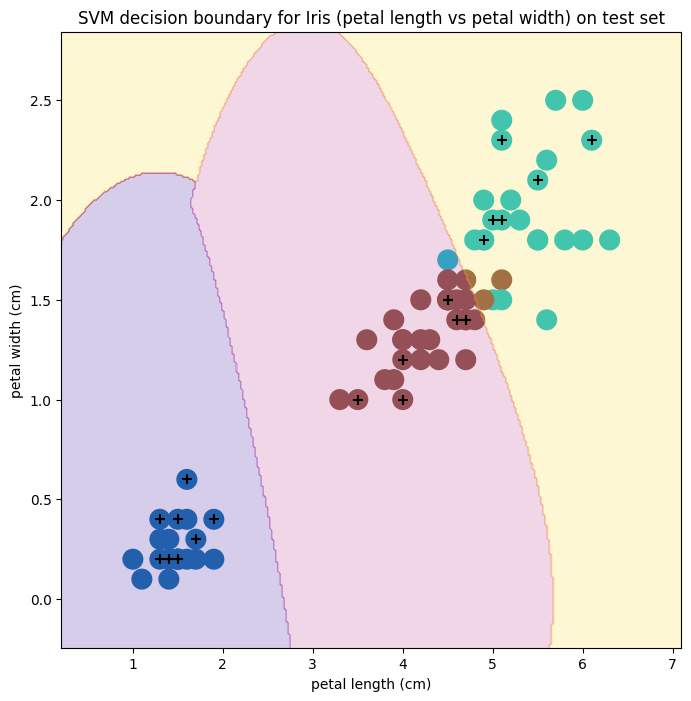

In [ ]:
svm_rbf=SVC(kernel="rbf", gamma =1, C=10, decision_function_shape='ovr' )

kfold=skm.KFold(n_splits=10, shuffle=True, random_state=0)
grid=skm.GridSearchCV(svm_rbf, {'C':[0.1,1,10,100,1000],
                                'gamma': [0.5,1,2,3,5]},
                      refit=True,
                      cv=kfold,
                      scoring='accuracy');

grid.fit(X_train, y_train)
print(grid.best_params_)

best_svm=grid.best_estimator_ #best SVM model, already fit on training data

# Training set
y_hat_train = best_svm.predict(X_train)
print("Train confusion:")
print(confusion_table(y_train, y_hat_train))
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train,
         y_train,
         best_svm,
         ax=ax,
         features=(2,3))
ax.set_title("Radial SVM decision boundary for Iris (petal length vs petal width) on training set")
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")

# Test set
y_hat_test = best_svm.predict(X_test)
print("Test confusion:")
print(confusion_table(y_test, y_hat_test))
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_test,
         y_test,
         best_svm,
         ax=ax,
         features=(2,3))
ax.set_title("SVM decision boundary for Iris (petal length vs petal width) on test set")
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")


Train confusion:
Truth       0   1   2
Predicted            
0          29   0   0
1           0  19   1
2           0   0  26
Test confusion:
Truth       0   1   2
Predicted            
0          21   0   0
1           0  29   1
2           0   2  22


Text(0, 0.5, 'petal width (cm)')

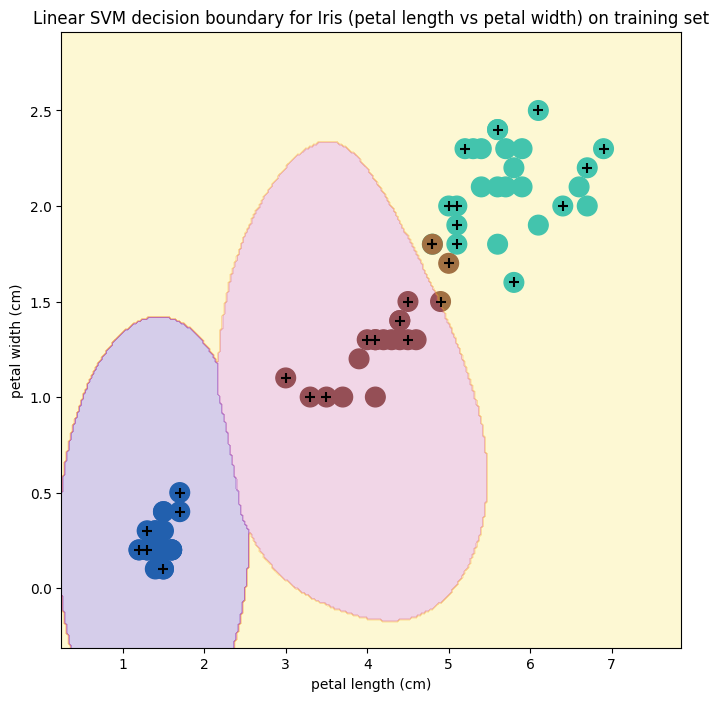

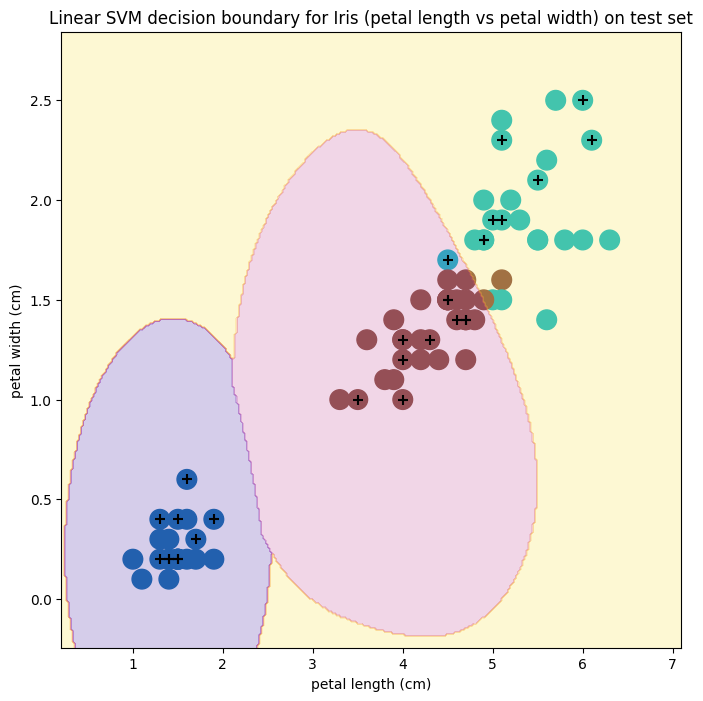

In [ ]:
svm_linear=SVC(kernel="linear", gamma =1, C=10, decision_function_shape='ovr' )
linear_grid=skm.GridSearchCV(svm_rbf, {'C':[0.1,1,10,100,1000]},
                      refit=True,
                      cv=kfold,
                      scoring='accuracy');

linear_grid.fit(X_train, y_train)
linear_best_svm=linear_grid.best_estimator_

# Training set
linear_y_hat_train = linear_best_svm.predict(X_train)
print("Train confusion:")
print(confusion_table(y_train, linear_y_hat_train))
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train,
         y_train,
         linear_best_svm,
         ax=ax,
         features=(2,3))
ax.set_title("Linear SVM decision boundary for Iris (petal length vs petal width) on training set")
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")

# Test set
linear_y_hat_test = linear_best_svm.predict(X_test)
print("Test confusion:")
print(confusion_table(y_test, linear_y_hat_test))
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_test,
         y_test,
         linear_best_svm,
         ax=ax,
         features=(2,3))
ax.set_title("Linear SVM decision boundary for Iris (petal length vs petal width) on test set")
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")



```



{'C': 1, 'degree': 1}
Train confusion:
Truth       0   1   2
Predicted            
0          29   0   0
1           0  19   1
2           0   0  26
Test confusion:
Truth       0   1   2
Predicted            
0          21   0   0
1           0  29   1
2           0   2  22


Text(0, 0.5, 'petal width (cm)')

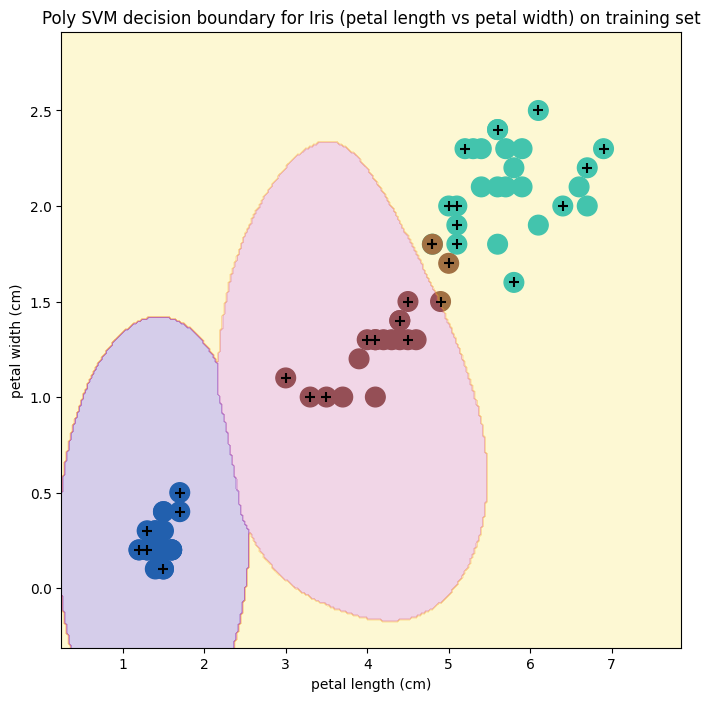

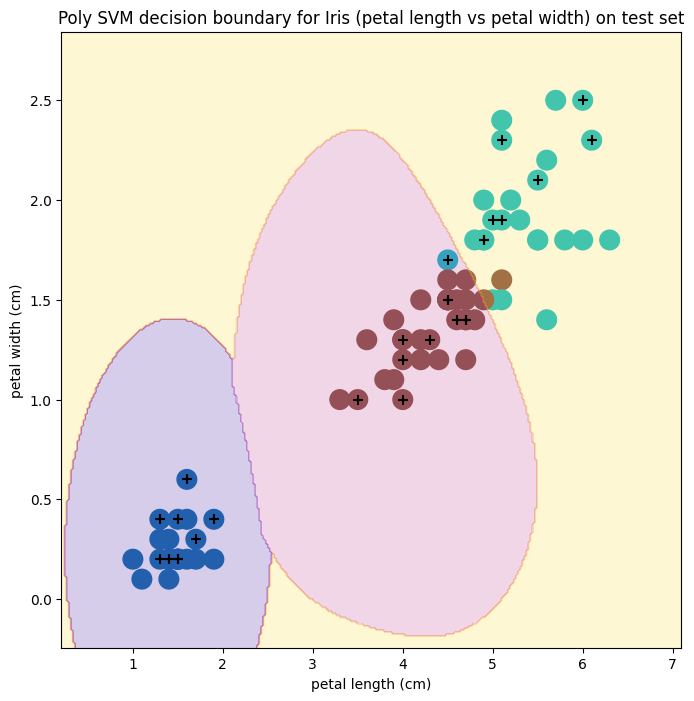

In [ ]:
svm_poly=SVC(kernel="poly", degree =1, C=10, decision_function_shape='ovr' )
poly_grid=skm.GridSearchCV(svm_rbf, {'C':[0.1,1,10,100,1000],
                                       'degree': [1,2,3,4,5]},
                      refit=True,
                      cv=kfold,
                      error_score='raise',
                      scoring='accuracy');

poly_grid.fit(X_train, y_train)
poly_best_svm=poly_grid.best_estimator_
print(poly_grid.best_params_)

# Training set
poly_y_hat_train = poly_best_svm.predict(X_train)
print("Train confusion:")
print(confusion_table(y_train, poly_y_hat_train))
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_train,
         y_train,
         poly_best_svm,
         ax=ax,
         features=(2,3))
ax.set_title("Poly SVM decision boundary for Iris (petal length vs petal width) on training set")
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")

# Test set
poly_y_hat_test = poly_best_svm.predict(X_test)
print("Test confusion:")
print(confusion_table(y_test, poly_y_hat_test))
fig, ax = subplots(figsize=(8, 8))
plot_svm(X_test,
         y_test,
         poly_best_svm,
         ax=ax,
         features=(2,3))
ax.set_title("Poly SVM decision boundary for Iris (petal length vs petal width) on test set")
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")


I fit SVM models using linear, polynomial, and RBF kernels and tuned their cost, degree, and gamma parameters with 10-fold cross-validation. The linear and polynomial SVMs produced identical results because the best polynomial model selected by cross-validation had degree = 1, which makes it equivalent to a linear classifier. Both the linear and polynomial models performed slightly better on the training set, misclassifying only 1 out of 75 observations (1.3%).

The RBF SVM made 2 training errors (2.7%), but it generalized better, it misclassified only 2 out of 75 test observations (2.7%), compared to 3 out of 75 test errors (4.0%) for the linear and polynomial models. Overall, all three models achieved high accuracy, but the RBF kernel handled the nonlinear boundary between versicolor and virginica slightly more effectively on the test data, while all models perfectly separated setosa.

In the 2D plots, it sometimes looks like there are more misclassified points than what appears in the confusion tables. This happens because the SVM is actually using all four features, so the true decision boundary lives in a 4-dimensional space. The plot is just a 2-dimensional slice (using petal length and petal width with the other features fixed), so some points can appear to lie in the “wrong” colored region even though they are classified correctly when all four features are taken into account. It would be better to look at PCA where dimensions are reduced.